In [4]:
import pandas as pd
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Memuat dataset baru
data = pd.read_csv('/content/Modified_SQL_Datasett.csv')

# Menampilkan beberapa baris pertama untuk memeriksa data
print(data.head())
print(data.info())

                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB
None


In [6]:
# Fungsi pembersihan teks
def clean_text(query):
    query = query.lower()  # Mengubah teks menjadi huruf kecil
    query = re.sub(r'\s+', ' ', query)  # Menghilangkan spasi berlebihan
    query = re.sub(r'[^\w\s]', '', query)  # Menghilangkan tanda baca
    return query

# Terapkan fungsi pembersihan ke kolom 'Query'
data['Cleaned_Query'] = data['Query'].astype(str).apply(clean_text)

# Melihat hasil pembersihan untuk memverifikasi
print(data[['Query', 'Cleaned_Query']].head())

                                               Query  \
0                  " or pg_sleep  (  __TIME__  )  --   
1  create user name identified by pass123 tempora...   
2   AND 1  =  utl_inaddr.get_host_address   (    ...   
3   select * from users where id  =  '1' or @ @1 ...   
4   select * from users where id  =  1 or 1#"  ( ...   

                                       Cleaned_Query  
0                            or pg_sleep  __time__    
1  create user name identified by pass123 tempora...  
2   and 1  utl_inaddrget_host_address   select di...  
3   select  from users where id  1 or  1  1 union...  
4   select  from users where id  1 or 1  union se...  


In [7]:
# Memisahkan data dan label dari dataset
queries = data['Query'].astype(str)  # pastikan tipe data string untuk tokenisasi
labels = data['Label'].astype(int)   # pastikan tipe data integer untuk label

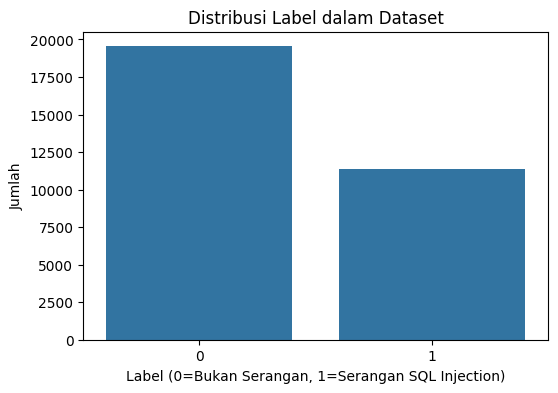

In [8]:
# Visualisasi distribusi label
plt.figure(figsize=(6, 4))
sns.countplot(x=data['Label'])
plt.title("Distribusi Label dalam Dataset")
plt.xlabel("Label (0=Bukan Serangan, 1=Serangan SQL Injection)")
plt.ylabel("Jumlah")
plt.show()

In [9]:
# Inisialisasi tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenisasi data teks
tokens = tokenizer(queries.tolist(), padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(tokens['input_ids'], labels, test_size=0.2, random_state=42)

# Membagi attention masks yang sesuai untuk data latih dan uji
attention_masks_train, attention_masks_test = train_test_split(tokens['attention_mask'], test_size=0.2, random_state=42)

In [11]:
from torch.utils.data import Dataset, DataLoader

# Membuat class Dataset
class SQLInjectionDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx],
            'attention_mask': self.masks[idx],
            'labels': self.labels[idx]
        }

# Menggunakan class Dataset untuk data latih dan data uji
train_dataset = SQLInjectionDataset(X_train, attention_masks_train, y_train)
test_dataset = SQLInjectionDataset(X_test, attention_masks_test, y_test)

In [12]:
# Menginisialisasi model BERT untuk klasifikasi sequence
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Fungsi evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [14]:
# Mengatur argumen pelatihan dengan precision campuran (Mixed Precision)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Meningkatkan batch size jika GPU mendukung
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    fp16=True  # Mengaktifkan mixed precision
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Pastikan semua data sudah di-reset indexnya setelah train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    tokens['input_ids'], labels, test_size=0.2, random_state=42
)
attention_masks_train, attention_masks_test = train_test_split(
    tokens['attention_mask'], test_size=0.2, random_state=42
)

# Reset index
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Mengonversi langsung ke tensor
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
attention_masks_train = torch.tensor(attention_masks_train)
attention_masks_test = torch.tensor(attention_masks_test)

<ipython-input-15-a7901594b191>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
<ipython-input-15-a7901594b191>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)
<ipython-input-15-a7901594b191>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks_train = torch.tensor(attention_masks_train)
<ipython-input-15-a7901594b191>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [16]:
# Dataset untuk Pelatihan
class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [17]:
# Membuat dataset pelatihan dan pengujian
train_dataset = TextClassificationDataset(
    encodings={'input_ids': X_train, 'attention_mask': attention_masks_train},
    labels=y_train
)

test_dataset = TextClassificationDataset(
    encodings={'input_ids': X_test, 'attention_mask': attention_masks_test},
    labels=y_test
)

In [18]:
# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [19]:
# Memulai pelatihan
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.036100,0.009948,0.997898,0.997162,0.997380,0.996945
2,0.000200,0.010756,0.998383,0.997818,0.997818,0.997818
3,0.000000,0.013521,0.998383,0.997816,0.998688,0.996945
4,0.000400,0.015104,0.998221,0.997599,0.997817,0.997381
5,0.014300,0.014928,0.998383,0.997818,0.997818,0.997818


TrainOutput(global_step=7730, training_loss=0.016361766441864576, metrics={'train_runtime': 3448.103, 'train_samples_per_second': 35.868, 'train_steps_per_second': 2.242, 'total_flos': 3.2540259771648e+16, 'train_loss': 0.016361766441864576, 'epoch': 5.0})

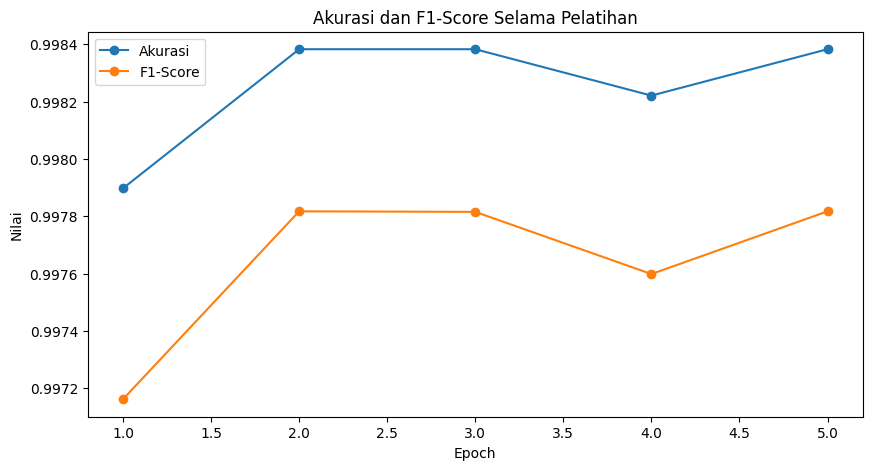

In [20]:
# Mengambil data log dari proses pelatihan
train_log = trainer.state.log_history

# Ekstraksi akurasi dan F1-score dari log
epochs = [log['epoch'] for log in train_log if 'eval_accuracy' in log]
accuracy = [log['eval_accuracy'] for log in train_log if 'eval_accuracy' in log]
f1_score = [log['eval_f1'] for log in train_log if 'eval_f1' in log]

# Visualisasi akurasi dan F1-score
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label="Akurasi", marker='o')
plt.plot(epochs, f1_score, label="F1-Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Nilai")
plt.title("Akurasi dan F1-Score Selama Pelatihan")
plt.legend()
plt.show()